In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import xarray as xr

import sys
import os.path as op
ROOT = op.abspath(op.join(op.pardir,op.pardir))
DATA_PATH = op.join(ROOT, 'data') + '/'
sys.path.insert(0, op.join(ROOT, 'src'))
import stationary_wave.tools as tl

import cartopy.crs as ccrs

%load_ext autoreload
%autoreload 2

In this notebook, we attempt to reproduce some results from Held et al 2002, Northern Winter Stationary Waves: Theory and Modeling (Journal of Climate).

We particularly focus on their figures 1 and 2.

Our results are quite similar but differ quantitatively, especially over North America, because we do not have the same heating field (compare the last figure of this notebook with their fig. 8)

# Eddy geopotential and streamfunction in NCEP-NCAR reanalysis

In [2]:
import dedalus.public as d3
def calc_helmholtz_ncep(u_xr):
    """Calculates a streamfunction and Helmholtz decomposition on reanalysis data output
    Here the streamfunction psi is defined such that laplacian(psi) = curl(u)
    args:
        - u_xr: xarray.DataArray
        Note u should not depend on time.
    returns:
        - xarray.Dataset with four variables: u_rot (rotational part of u), 
        u_div (divergent part of u), div (divergence of u), and psi (streamfunction)
    """
    meter = 1 / 6.37122e6 # To perform the numerical calculation, we rescale all lengths by Earth's radius 
    second = 1./3600

    dealias = (3/2,3/2)
    dtype = np.float64
    Nphi = len(u_xr.lon)
    Ntheta = len(u_xr.lat)
    
    coords = d3.S2Coordinates('phi', 'theta')
    dist = d3.Distributor(coords, dtype=dtype)
    basis = d3.SphereBasis(coords, (Nphi, Ntheta), radius=6.37122e6 * meter, dealias=dealias, dtype=dtype)
    
    u_xr = u_xr.transpose('','lon','lat')
    u_xr[1] = -u_xr[1] # flip the sign of the v-component because of the dedalus convention
        
    u = dist.VectorField(coords, name='u', bases=basis)
    u_rot = dist.VectorField(coords, name='u_rot', bases=basis)
    u.load_from_global_grid_data(u_xr.data * meter / second)
    
    # Solve a Poisson equation for the streamfunction (curl of u is div(skew(u)))
    c = dist.Field(name='c')
    psi = dist.Field(name='psi', bases=basis)
    problem = d3.LBVP([c, psi], namespace=locals())
    problem.add_equation("lap(psi) + c = - div(skew(u))")
    problem.add_equation("ave(psi) = 0") # Gauge condition to ensure a unique solution
    solver = problem.build_solver()
    solver.solve()
    
    u_rot = d3.skew(d3.grad(psi)).evaluate()
    divu = d3.div(u).evaluate()
    
    u.change_scales(1)
    u_rot.change_scales(1)
    divu.change_scales(1)
    psi.change_scales(1)
    
    # placeholder for u_rot and u_div
    
    u_rot_xr = 0. * u_xr.rename('u_rot')
    u_div_xr = 0. * u_xr.rename('u_div')
    divu_xr = 0. * u_xr.isel({'':0}).rename('div')
    psi_xr  = 0. * u_xr.isel({'':0}).rename('psi')

    psi_xr[:] = psi['g']
    u_rot_xr[:] = u_rot['g']
    u_div_xr[:] = u['g']-u_rot['g']
    divu_xr[:] = divu['g']
        
    return xr.merge((u_rot_xr / (meter/second), 
                     u_div_xr / (meter/second),
                     psi_xr / (meter**2 / second),
                     divu_xr / (1/second))).transpose('','lat','lon')

In [10]:
ncep_jan_all_mean = xr.open_dataset(DATA_PATH + "input/ncep_jan_all_mean.nc")

In [11]:
U_xr = xr.concat([ncep_jan_all_mean.U, ncep_jan_all_mean.V],dim='').sel(level=300)
helmhotz  = calc_helmholtz_ncep(U_xr)

2025-09-11 12:05:38,977 subsystems 0/1 INFO :: Building subproblem matrices 1/72 (~1%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+02/s
2025-09-11 12:05:38,989 subsystems 0/1 INFO :: Building subproblem matrices 8/72 (~11%) Elapsed: 0s, Remaining: 0s, Rate: 5.5e+02/s
2025-09-11 12:05:39,002 subsystems 0/1 INFO :: Building subproblem matrices 16/72 (~22%) Elapsed: 0s, Remaining: 0s, Rate: 5.8e+02/s
2025-09-11 12:05:39,015 subsystems 0/1 INFO :: Building subproblem matrices 24/72 (~33%) Elapsed: 0s, Remaining: 0s, Rate: 5.9e+02/s
2025-09-11 12:05:39,028 subsystems 0/1 INFO :: Building subproblem matrices 32/72 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 6.0e+02/s
2025-09-11 12:05:39,041 subsystems 0/1 INFO :: Building subproblem matrices 40/72 (~56%) Elapsed: 0s, Remaining: 0s, Rate: 6.0e+02/s
2025-09-11 12:05:39,054 subsystems 0/1 INFO :: Building subproblem matrices 48/72 (~67%) Elapsed: 0s, Remaining: 0s, Rate: 6.0e+02/s
2025-09-11 12:05:39,066 subsystems 0/1 INFO :: Building subproblem matri

Text(0.5, 1.0, 'Streamfunction 300hPa NCEP-NCAR 1948-1999 Jan')

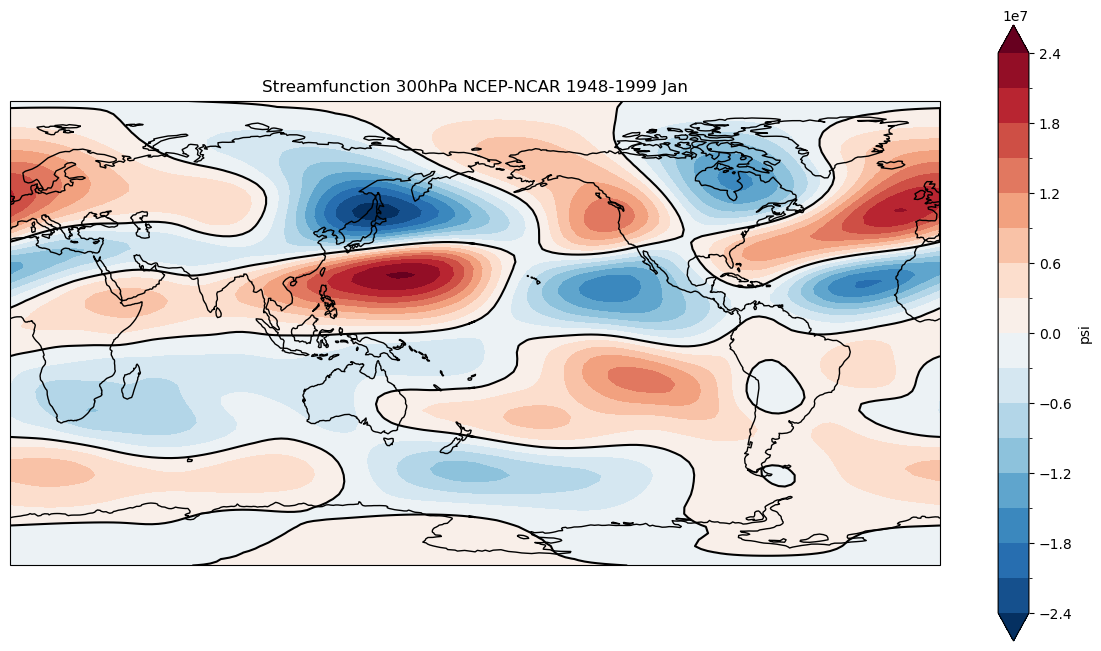

In [14]:
_,ax = plt.subplots(1, 1, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
psiprime = tl.wrap_lon(helmhotz.psi - helmhotz.psi.mean('lon'))
psiprime.plot.contourf(ax = ax, transform = ccrs.PlateCarree(),levels=np.arange(-24,25,3) * 1e6, cmap = 'RdBu_r')
psiprime.plot.contour(ax = ax, transform = ccrs.PlateCarree(),levels=[0.,], colors = 'k')
ax.coastlines()
ax.set_title("Streamfunction 300hPa NCEP-NCAR 1948-1999 Jan")

# Stationary wave model results

In [38]:
def process_sim_withHelmholtz(snapshot_id,avg = np.array([30,50])):
    sim = tl.process_sigma_sim(snapshot_id,('s1',),avg = avg)

    ps = 1e3 * np.exp(sim.lnpsbar + sim.lnps_mean / 1e2)

    helm = tl.calc_helmholtz(sim.u_mean.isel(longitude=slice(None,-1))) # remove last longitude point so that things work well with Dedalus

    helm = helm.assign_coords(pressure=helm.sigma * ps)
    helm_300 = xr.apply_ufunc(lambda sig,y : np.interp(300.,sig,y),
                            helm.pressure,
                            helm,
                            input_core_dims=(('sigma',),('sigma',)),
                            vectorize=True)
    helm_300 = helm_300.rename(u_rot = 'u_rot_300', u_div = 'u_div_300', psi = 'psi_300', div = 'div_300')
    helm_300 = tl.wrap_lon(helm_300).isel(longitude=slice(1,None)) # Add last longitude point back
    return xr.merge([sim, helm_300]).transpose('t','','latitude','longitude','sigma','sigma_stag')

In [ ]:
orog_linear_T32 = process_sim_withHelmholtz('stationarywave_14level_T32_held2002_orog_linear')
all_linear_T32 = process_sim_withHelmholtz('stationarywave_14level_T32_held2002_all_linear')
emfd_linear_T32 = process_sim_withHelmholtz('stationarywave_14level_T32_held2002_emfd_linear')
heat_linear_T32 = process_sim_withHelmholtz('stationarywave_14level_T32_held2002_heat_linear')

2025-09-11 12:49:40,660 subsystems 0/1 INFO :: Building subproblem matrices 1/31 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 3.8e+02/s
2025-09-11 12:49:40,665 subsystems 0/1 INFO :: Building subproblem matrices 4/31 (~13%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+02/s
2025-09-11 12:49:40,672 subsystems 0/1 INFO :: Building subproblem matrices 8/31 (~26%) Elapsed: 0s, Remaining: 0s, Rate: 5.6e+02/s
2025-09-11 12:49:40,679 subsystems 0/1 INFO :: Building subproblem matrices 12/31 (~39%) Elapsed: 0s, Remaining: 0s, Rate: 5.5e+02/s
2025-09-11 12:49:40,688 subsystems 0/1 INFO :: Building subproblem matrices 16/31 (~52%) Elapsed: 0s, Remaining: 0s, Rate: 5.2e+02/s
2025-09-11 12:49:40,695 subsystems 0/1 INFO :: Building subproblem matrices 20/31 (~65%) Elapsed: 0s, Remaining: 0s, Rate: 5.3e+02/s
2025-09-11 12:49:40,702 subsystems 0/1 INFO :: Building subproblem matrices 24/31 (~77%) Elapsed: 0s, Remaining: 0s, Rate: 5.4e+02/s
2025-09-11 12:49:40,709 subsystems 0/1 INFO :: Building subproblem matric

Text(0.5, 1.0, 'Convergence of global mean enstrophy in stationary wave simulations')

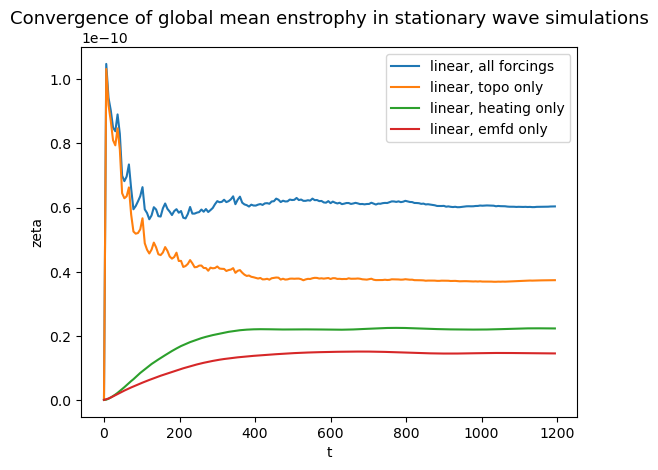

In [73]:
# CONVERGENCE
(all_linear_T32.zeta**2).mean(('longitude','latitude','sigma')).plot(label='linear, all forcings')
(orog_linear_T32.zeta**2).mean(('longitude','latitude','sigma')).plot(label='linear, topo only')
(heat_linear_T32.zeta**2).mean(('longitude','latitude','sigma')).plot(label='linear, heating only')
(emfd_linear_T32.zeta**2).mean(('longitude','latitude','sigma')).plot(label='linear, emfd only')
plt.legend()
plt.title('Convergence of global mean enstrophy in stationary wave simulations', fontsize=13)

Text(0.5, 0.98, 'January basic state from NCEP-NCAR reanalysis')

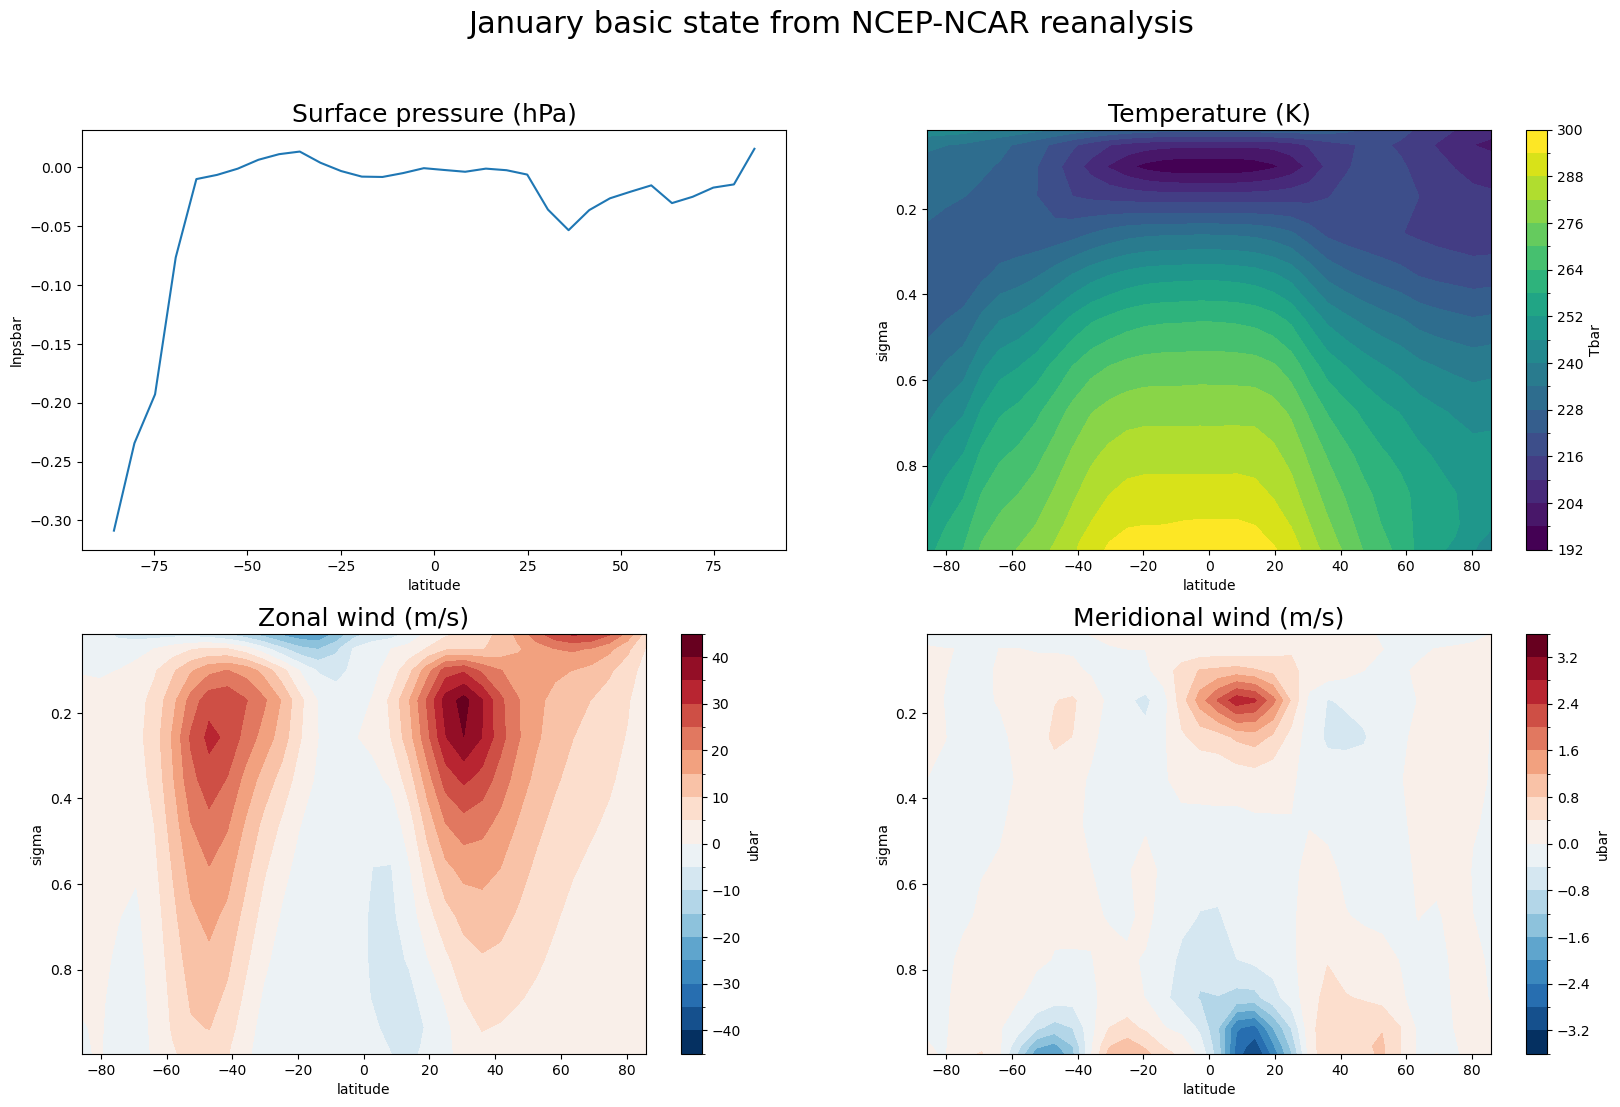

In [52]:
# basic state
fig,axs = plt.subplots(2,2,figsize=(20,12)); axs=axs.reshape(-1)
for i,(ax,var) in enumerate(zip(axs,(orog_linear_T32.lnpsbar,orog_linear_T32.Tbar,orog_linear_T32.ubar[0],-orog_linear_T32.ubar[1]))):
    if i==0:
        var.plot(ax=ax)
    else:
        var.plot.contourf(ax=ax,y='sigma',yincrease=False,levels=21)
for ax,name in zip(axs,('Surface pressure (hPa)','Temperature (K)','Zonal wind (m/s)','Meridional wind (m/s)')):
    ax.set_title(name,fontsize=18)
fig.suptitle('January basic state from NCEP-NCAR reanalysis',fontsize=22)

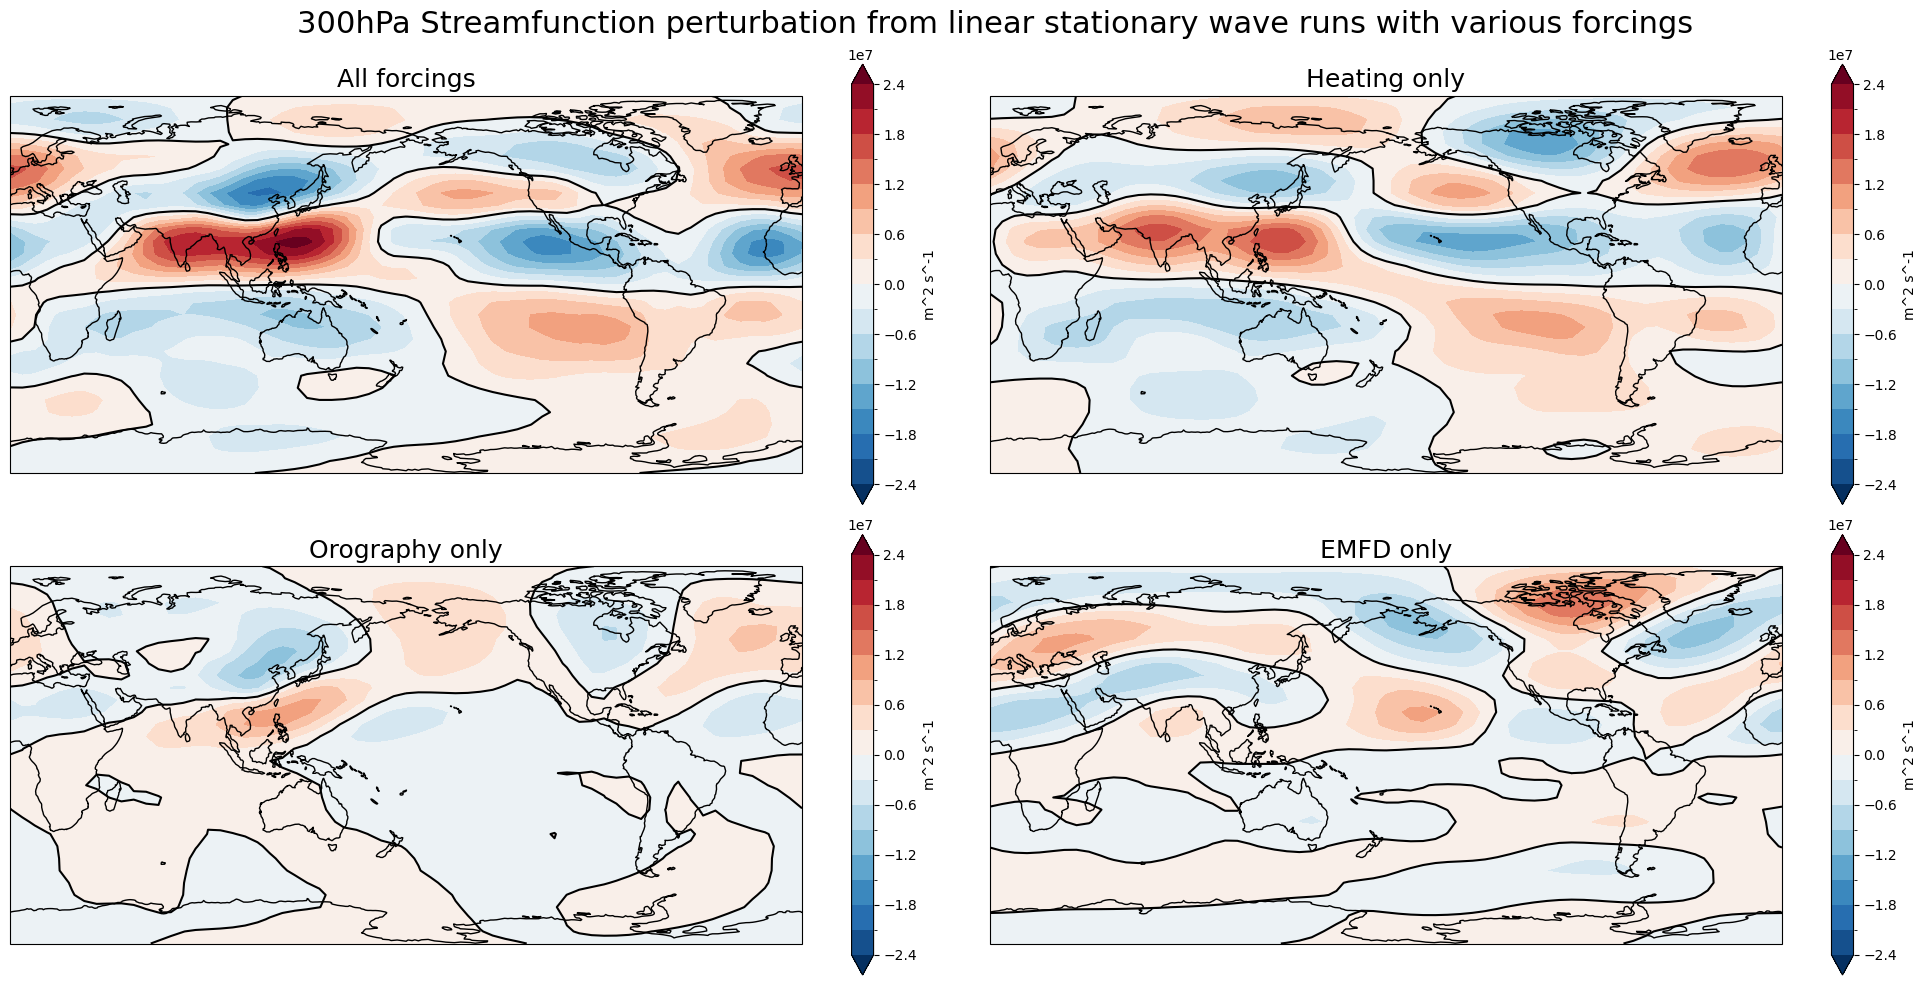

In [ ]:
fig,axs = plt.subplots(2, 2, figsize=(20,10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
for ax,sim,ttl in zip(axs.flatten(),
                      (all_linear_T32,heat_linear_T32,orog_linear_T32,emfd_linear_T32),
                      ('All forcings','Heating only','Orography only','EMFD only')):
    psiprime = sim.psi_300 
    psiprime.plot.contourf(ax = ax, transform = ccrs.PlateCarree(),levels=np.arange(-24,25,3) * 1e6, 
                           cmap = 'RdBu_r',extend='both', cbar_kwargs={'label':'m^2 s^-1'})
    psiprime.plot.contour(ax = ax, transform = ccrs.PlateCarree(),levels=[0.,], colors = 'k')
    ax.coastlines()
    ax.set_title(ttl,fontsize=18)
fig.suptitle('300hPa Streamfunction perturbation from linear stationary wave runs with various forcings',fontsize=22)
fig.tight_layout()

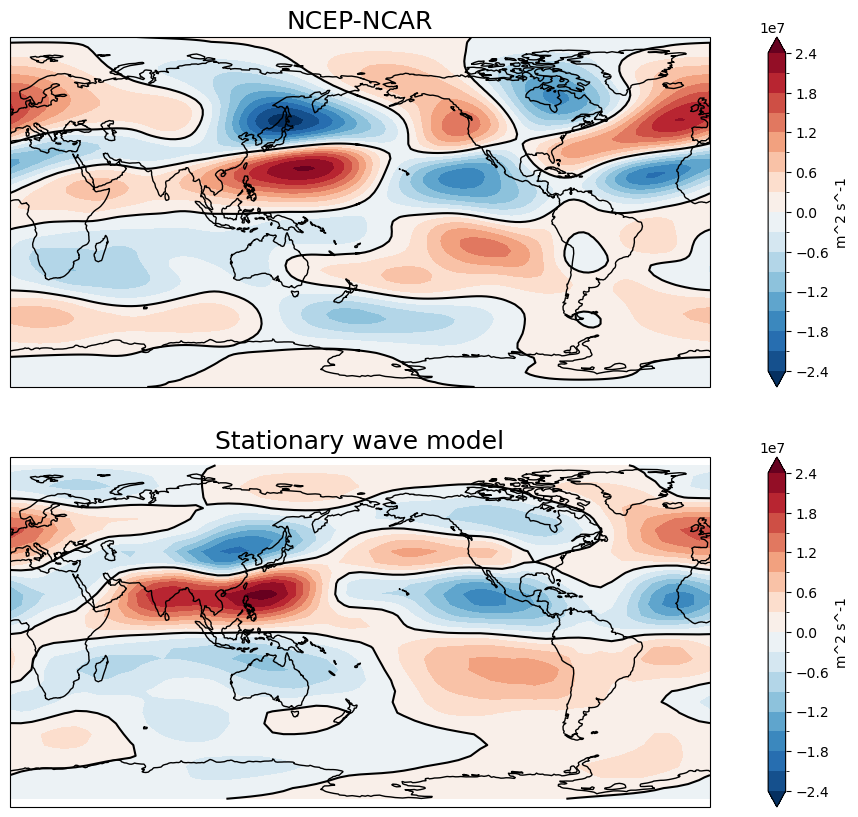

In [70]:
# all forcings, new damping
fig,axs = plt.subplots(2, 1, figsize=(15,10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
for ax,psiprime,ttl in zip(axs.flatten(),
                      (tl.wrap_lon(helmhotz.psi - helmhotz.psi.mean('lon')),all_linear_T32.psi_300 ),
                      ('NCEP-NCAR','Stationary wave model')):
    psiprime.plot.contourf(ax = ax, transform = ccrs.PlateCarree(),levels=np.arange(-24,25,3) * 1e6, 
                           cmap = 'RdBu_r',extend='both', cbar_kwargs={'label':'m^2 s^-1'})
    psiprime.plot.contour(ax = ax, transform = ccrs.PlateCarree(),levels=[0.,], colors = 'k')
    ax.coastlines()
    ax.set_title(ttl,fontsize=18)
    ax.set_extent([0,360,-90,90],crs=ccrs.PlateCarree())
# fig.suptitle('300hPa Streamfunction perturbation from NCEP-NCAR reanalysis vs stationary wave',fontsize=22)


Text(0.5, 1.0, 'Qdiab diagnosed from NCEP as a residual of the thermo eqn')

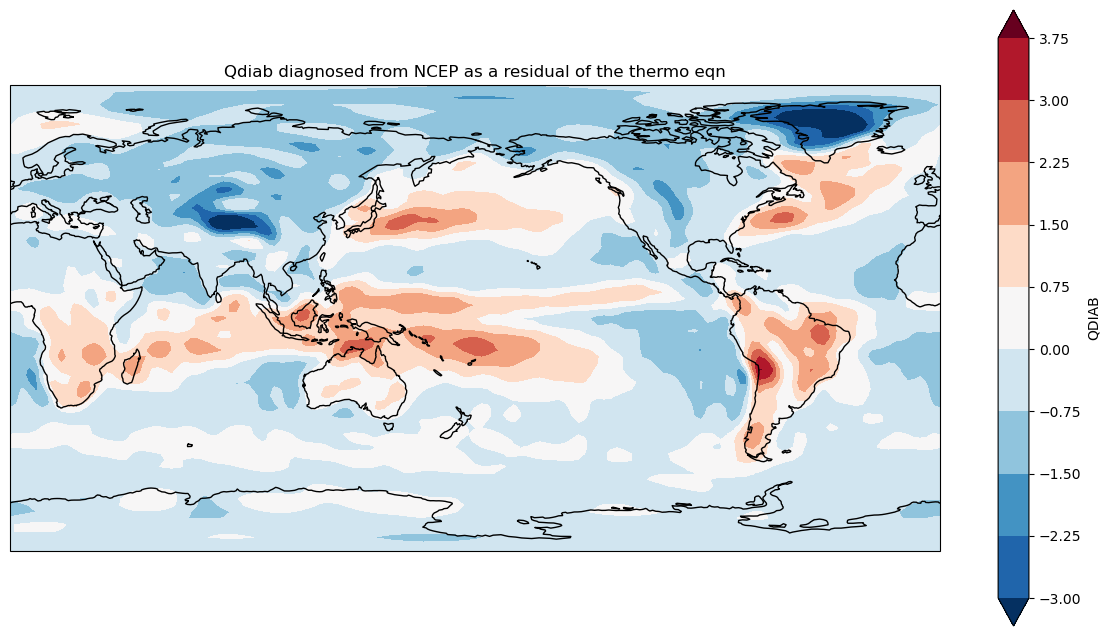

In [63]:
forcings = xr.open_dataset(DATA_PATH + "input/ncep_jan_forcings.nc")
_,ax = plt.subplots(1, 1, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
tl.wrap_lon(forcings.QDIAB.integrate('pressure') * 86400 / 990).plot.contourf(ax = ax, transform = ccrs.PlateCarree(),levels=np.arange(-3,3.76,0.75), cmap = 'RdBu_r',extend='both')
ax.coastlines()
ax.set_title("Qdiab diagnosed from NCEP as a residual of the thermo eqn")